In [1]:
import cv2
import numpy as np

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab

%matplotlib inline

print "OpenCV Version ", cv2.__version__

OpenCV Version  3.1.0


In [2]:
def segment_fruit(image):
    
    # Limiariza cada um dos canais de forma independente
    ret, imR = cv2.threshold(image[:,:,0],0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    ret, imG = cv2.threshold(image[:,:,1],0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    ret, imB = cv2.threshold(image[:,:,2],0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # Combina as segmentações utilizando o operador OR
    segmentation = imR | imG | imB

    # Preencha as regiões que não foram corretamente detectadas
    im_floodfill = segmentation.copy()
    h, w = segmentation.shape[:2]
    maskT = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(im_floodfill, maskT, (0,0), 255);
    segmentation_filled = segmentation | ~im_floodfill

    # Desenhe apenas o maior objeto presente na imagem
    im2, contours, hierarchy = cv2.findContours(segmentation_filled.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]

    final_segmentation = np.zeros((h, w), np.uint8)
    cv2.drawContours(final_segmentation, [contours[0]], 0, 1, cv2.FILLED)
    
    # Retorne a imagem segmentada
    return final_segmentation > 0.5, contours[0]

True

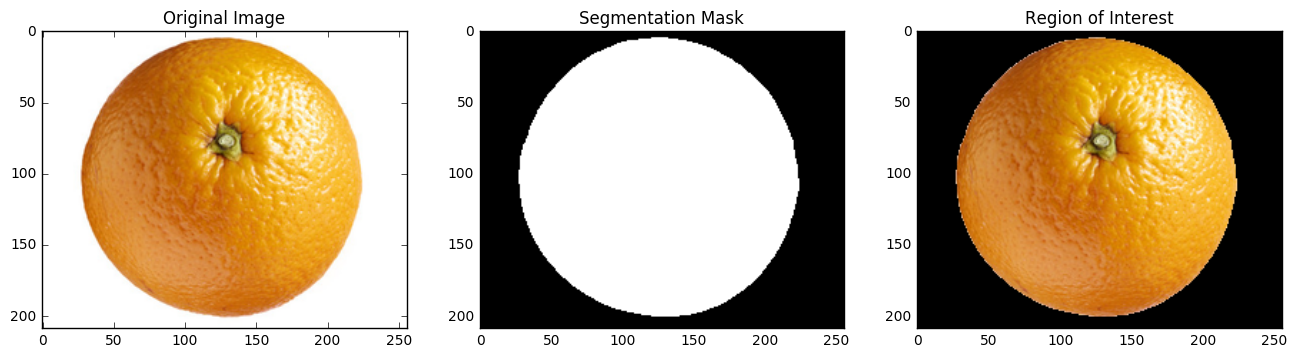

In [3]:
imageBGR = cv2.imread('orange/4.png')
imageRGB = cv2.cvtColor(imageBGR, cv2.COLOR_BGRA2RGB)

segmentationBin, contour = segment_fruit(imageRGB)
segmentation = np.dstack( (segmentationBin, segmentationBin, segmentationBin) ) * 255.0

pylab.rcParams['figure.figsize'] = (16, 6)
plt.figure
plt.subplot(1,3,1)
plt.title('Original Image')
plt.imshow(imageRGB)
plt.subplot(1,3,2)
plt.title('Segmentation Mask')
plt.imshow(segmentationBin, 'gray')
plt.subplot(1,3,3)
plt.title('Region of Interest')
plt.imshow(segmentation * imageRGB)

In [4]:
def get_dominant_color(image, segmentation):
    
    # Cria uma mascara para selecionar apenas os pixels que pertencem a região da fruta
    mask = np.zeros(image.shape[:2], np.uint8) + segmentation
    
    # Estima a cor media da região da fruta
    mean_color = np.uint8(cv2.mean(image, mask=mask))[:3]
    
    # Retorna um vetor com os valores medios para os canais R, G, B
    return mean_color

[218 146  44]


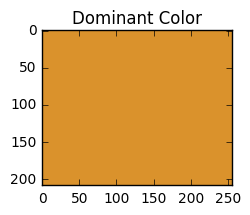

In [5]:
mean_color = get_dominant_color(imageRGB, segmentationBin)

print mean_color

h, w, d = imageRGB.shape
dominant_color = np.ones( (h, w, 3), np.uint8 ) * mean_color
pylab.rcParams['figure.figsize'] = (5, 2)
plt.title('Dominant Color')
plt.imshow(dominant_color)

In [6]:
def get_fruit_struct(image, contour):
    # Estima o quadrado que envolve toda a area da fruta
    x, y, w, h = cv2.boundingRect(contour)
    
    # Computa a razao entre o eixo vertical e horizontal
    aspect_ratio = float(w)/h
    
    return aspect_ratio

1.00510204082


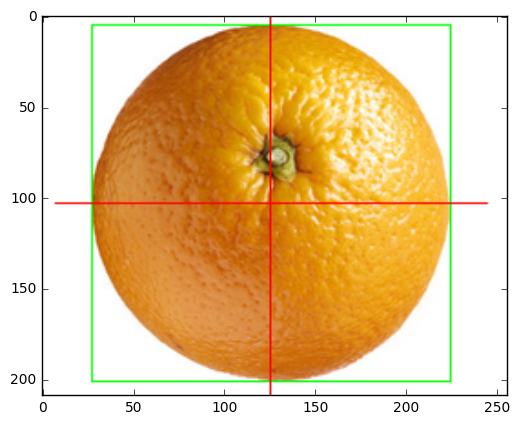

In [7]:
x,y,w,h = cv2.boundingRect(contour)


box_image = imageRGB.copy()
# Desenhando a caixa envoltoria (bounding box)
cv2.rectangle(box_image, (x, y), (x + w, y + h), (0, 255, 0), 1)

# Desenhando os eixos principais
border = 20
cv2.line(box_image, (x-border,y+(h/2)), (x+w+border,  y+(h/2)), (255, 0, 0), 1)
cv2.line(box_image, (x+(w/2),y-border), (x+(w/2),  y+h+border), (255, 0, 0), 1)

pylab.rcParams['figure.figsize'] = (6, 6)
plt.imshow(box_image)

aspect_ratio = get_fruit_struct(imageRGB, contour)
print aspect_ratio

In [8]:
label = {0: 'laranja', 1: 'maca'}

X = np.array([[ 244,          146,           10,            0.95375723],
     [ 247,          129,            8,            1.00436681],
     [ 204,          135,           20,            1.00823045],
     [ 244,          161,           43,            0.955     ],
     [ 253,          138,            6,            1.02966102],
     [ 233,          148,           43,            1.04929577],
     [ 234,          145,           32,            1.09714286],
     [ 218,          146,           44,            1.00510204],
     [ 209,          135,           31,            1.016     ],
     [ 241,          141,           25,            0.97272727],
     [ 236,           77,           91,            1.02564103],
     [ 116,           45,           42,            1.01337449],
     [ 206,          111,           68,            0.84108527],
     [ 185,           79,           60,            0.86826347],
     [ 202,           79,           48,            0.99494949],
     [ 175,           75,           57,            0.83622829],
     [ 150,          161,           54,            1.23076923],
     [ 219,          104,           61,            0.82346241],
     [ 228,          130,           38,            1.09579439],
     [ 131,          164,           28,            0.93048128]])

y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

out = [label[i] for i in y]
print out

['laranja', 'laranja', 'laranja', 'laranja', 'laranja', 'laranja', 'laranja', 'laranja', 'laranja', 'laranja', 'maca', 'maca', 'maca', 'maca', 'maca', 'maca', 'maca', 'maca', 'maca', 'maca']


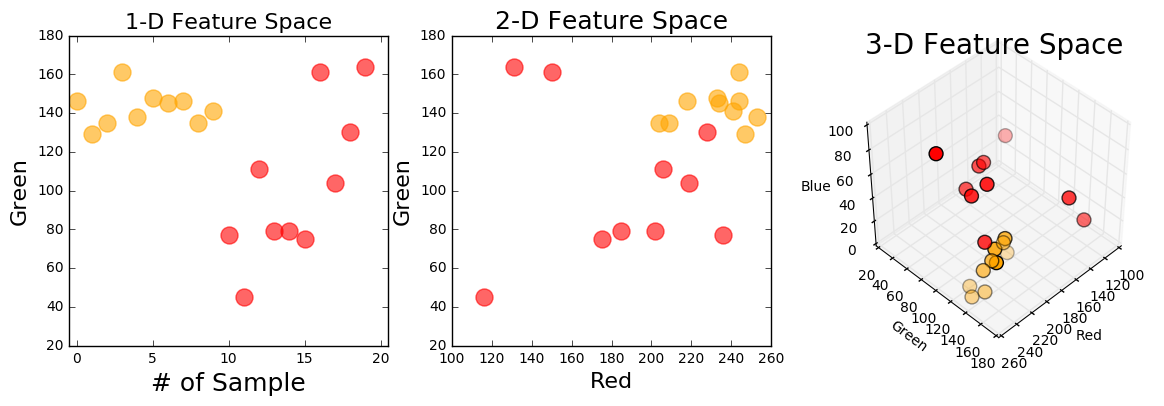

In [9]:
pylab.rcParams['figure.figsize'] = (14, 4)
plt.figure()
# ---------------------------------------------------------
plt.subplot(1,3,1)

plt.scatter(np.linspace(0,   9, 10), X[:10, 1], s=150, color='orange', alpha = 0.6)
plt.scatter(np.linspace(10, 19, 10), X[10:, 1], s=150, color='red', alpha = 0.6)

plt.xlabel('# of Sample',   fontsize=18)
plt.ylabel('Green',           fontsize=16)
plt.title('1-D Feature Space', fontsize = 16)

ret = plt.xlim([-.5, 20.5])
# ---------------------------------------------------------
plt.subplot(1,3,2)

plt.title('2-D Feature Space', fontsize = 18)
plt.xlabel('Red',   fontsize=16)
plt.ylabel('Green', fontsize=16)

plt.scatter(X[:10, 0], X[:10, 1], s = 150, color='orange', alpha = 0.6)
plt.scatter(X[10:, 0], X[10:, 1], s = 150, color='red', alpha = 0.6)

# ---------------------------------------------------------
ax = plt.subplot(1,3,3, projection='3d')
plt.title('3-D Feature Space', fontsize = 20)
ax.dist=15
ax.view_init(elev=45, azim=45) 

ax.scatter(X[:10, 0], X[:10, 1], X[:10, 2], s=100, c='orange')
ax.scatter(X[10:, 0], X[10:, 1], X[10:, 2], s=100, c='red')

ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')

In [10]:
X_train = X[0:20:2, :];
y_train = y[0:20:2];

X_test = X[1:20:2, :];
y_test = y[1:20:2];

model = LinearDiscriminantAnalysis()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print "Prediction:"
print y_pred

print "Expected Labels:"
print y_test

print "Accuracy:"
print ( np.sum(y_test == y_pred) / np.float(len(y_test)) ) * 100, '%'

Prediction:
[0 0 0 0 0 1 1 1 1 0]
Expected Labels:
[0 0 0 0 0 1 1 1 1 1]
Accuracy:
90.0 %
